In [1]:
#including libraries
import numpy as np                          #scientific computing
from numpy.linalg import inv,det            # matrix operations
import numpy.random as ran 
import matplotlib.pyplot as plt             #plot library
from scipy.io import loadmat                #import mat data

# Extended Kalman Filter

In [2]:
# Import data

mat_file = loadmat('par.mat')

# constants
A = mat_file["A"][:,:]
B = mat_file["B"][:,:]
W = mat_file["W"][:,:]
h = mat_file["h"][:,:]
Gamma = mat_file["Gamma"][:,:]
Sigma = mat_file["Sigma"][:,:]
mu0 = mat_file["mu0"][:,:]

## a) Create latent and observed states

In [3]:
# Define non-linear map
def phi(z):
    return np.maximum(np.zeros((len(z))), z)

In [4]:
ran.seed(1)

T = 500  # length of time series
N = 10   # observation dimension
M = 3    # latent dimension

z = np.zeros((M, T))   # latent states
x = np.zeros((N, T))   # observed states

z[:, 0] = ran.multivariate_normal(np.squeeze(mu0), Sigma)   # initial random value of z
x[:, 0] = B.dot(z[:,0]) + ran.multivariate_normal(np.zeros((N)).T, Gamma)

# Generate TS
for t in range(1, T):
    z[:,t] = A.dot(z[:,t-1]) + W.dot(phi(z[:,t-1])) + np.squeeze(h) + ran.multivariate_normal(np.zeros((M)).T, Sigma) 
    x[:,t] = B.dot(z[:,t]) + ran.multivariate_normal(np.zeros((N)).T, Gamma)

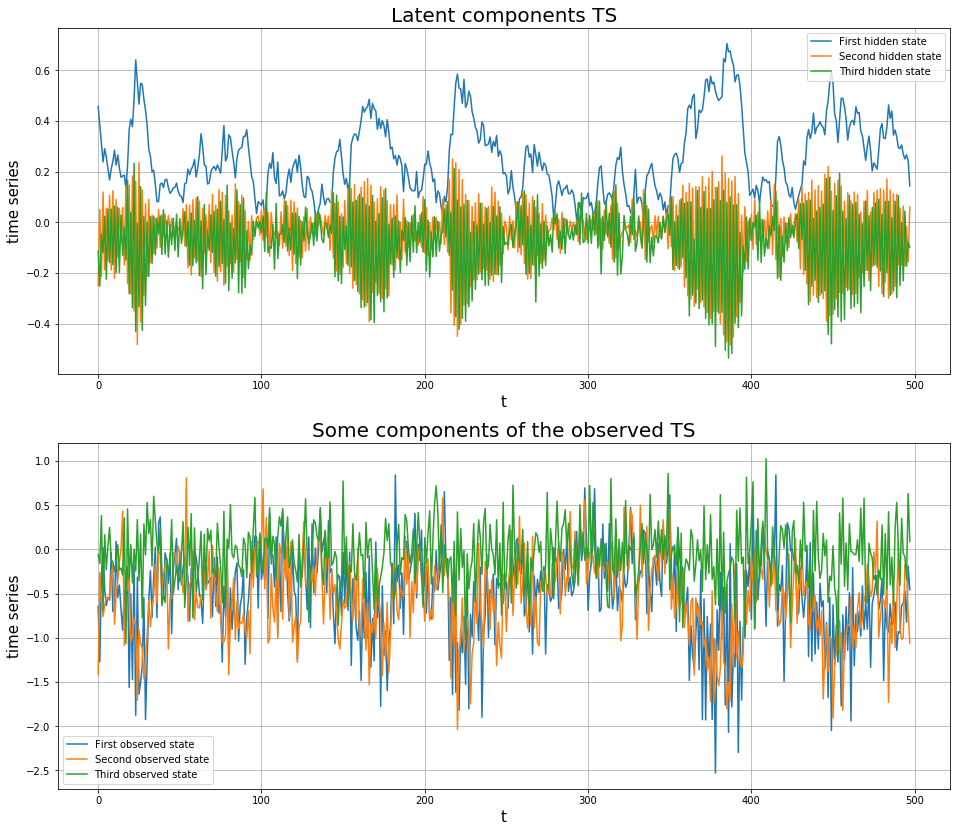

In [5]:
# Plot the series 
fig = plt.subplots(figsize=[16,14])

plt.subplot(2,1,1)
plt.plot(z[0,2:], label='First hidden state')
plt.plot(z[1,2:], label='Second hidden state')
plt.plot(z[2,2:], label='Third hidden state')
plt.xlabel('t', fontsize=15)
plt.ylabel('time series', fontsize=15)
plt.title('Latent components TS', fontsize=20)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(x[0,2:], label='First observed state')
plt.plot(x[1,2:], label='Second observed state')
plt.plot(x[2,2:], label='Third observed state')
plt.xlabel('t', fontsize=15)
plt.ylabel('time series', fontsize=15)
plt.title('Some components of the observed TS', fontsize=20)
plt.legend()
plt.grid()

plt.show(fig)

## b) Run the Kalman filter

### Kalman filter implemented in Exercise 5

In [6]:
# Define function for Kalman filter (compute mean and variance at each step)

def Kalman_filter(x, A, B, Sigma, Gamma, mu0, C=None, u=None):
    
    k = x.shape[0]     # dimension of observed state
    l = x.shape[1]     # lenght of observations
    p = Sigma.shape[0] # dimension of latent state
    
    L0 = Sigma   # initial covariance matrix
    
    K0 = (L0.dot(B.T)).dot(inv(B.dot(L0.dot(B.T)) + Gamma))    # initial Kalman gain matrix
    V0 = (np.identity(p) - K0.dot(B)).dot(L0)                  # initial variance matrix
    
    # Define and compute means and variances at each step
    
    mu = np.zeros((p,l))     # means vector
    mu[:,0] = np.squeeze(mu0)
    
    V = np.zeros((p,p,l))    # variance matrix vector
    V[:,:,0] = V0
    
    # are control variables entered? if not, set to 0
    if C is None and u is None:
        C = np.zeros((p, k))
        u = np.zeros((k, l))
    
    for t in range(1, l):
        L = ((A.dot(V[:,:,t-1])).dot(A.T) + Sigma)
        K = (L.dot(B.T)).dot(inv(B.dot(L.dot(B.T)) + Gamma))    # Kalman Gain matrix
        
        mu[:,t] = A.dot(mu[:,t-1]) + C.dot(u[:,t]) + K.dot(x[:,t] - B.dot(A.dot(mu[:,t-1]) + C.dot(u[:,t])))
        V[:,:,t] = (np.identity(p) - K.dot(B)).dot(L)
    
    return mu, V

In [7]:
# Get mean and variance matrix at each time step
mu_KF, V_KF = Kalman_filter(x, A, B, Sigma, Gamma, mu0)

## c) Implement the extended Kalman filter (EKF)

In [8]:
def Extended_Kalman_filter(x, A, B, W, Sigma, Gamma, mu0, C=None, u=None):
    
    k = x.shape[0]     # dimension of observed state
    l = x.shape[1]     # lenght of observations
    p = Sigma.shape[0] # dimension of latent state
    
    L0 = Sigma   # initial covariance matrix
    
    K0 = (L0.dot(B.T)).dot(inv(B.dot(L0.dot(B.T)) + Gamma))    # initial Kalman gain matrix (same as before because the observation model is linear)
    V0 = (np.identity(p) - K0.dot(B)).dot(L0)                  # initial variance matrix
    
    # Define and compute means and variances at each step
    
    mu = np.zeros((p,l))     # means vector
    mu[:,0] = np.squeeze(mu0)
    
    V = np.zeros((p,p,l))    # variance matrix vector
    V[:,:,0] = V0
    
    # are control variables entered? if not, set to 0
    if C is None and u is None:
        C = np.zeros((p, k))
        u = np.zeros((k, l))
    
    for t in range(1, l):
        ipos = np.where(mu[:,t-1]>0)  # find where mean is positive, to compute derivatives
        deriv = np.zeros((p))
        deriv[ipos] = 1.        # compute derivative of the linear activation function
        J = A + W.dot(np.diag(deriv))   # jacobian matrix
        L = ((J.dot(V[:,:,t-1])).dot(J.T) + Sigma)
        K = (L.dot(B.T)).dot(inv(B.dot(L.dot(B.T)) + Gamma))    # Kalman Gain matrix
        
        mu[:,t] = A.dot(mu[:,t-1]) + W.dot(phi(mu[:,t-1])) + K.dot(x[:,t] - B.dot(A.dot(mu[:,t-1]) + W.dot(phi(mu[:,t-1]))))
        V[:,:,t] = (np.identity(p) - K.dot(B)).dot(L)
    
    return mu, V    

In [9]:
# Get mean and variance matrix at each time step for the Extended version
mu_EKF, V_EKF = Extended_Kalman_filter(x, A, B, W, Sigma, Gamma, mu0)

## d) Compare the obtained estimate between the Kalman filter and the EKF


 MSE with Kalman Filter : 0.0129

 MSE with Extended Kalman Filter : 0.0022


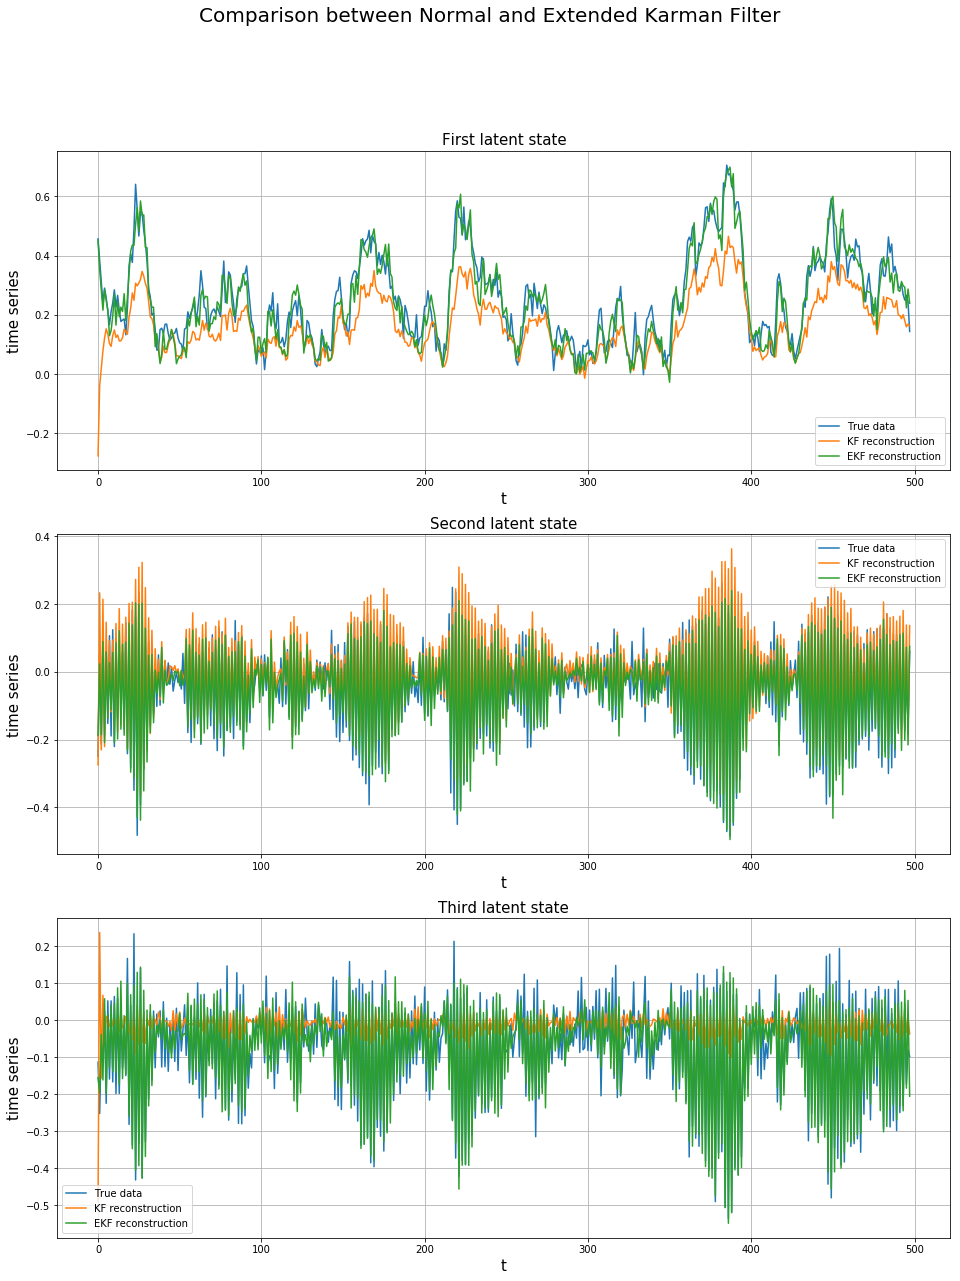

In [10]:
fig_compare = plt.subplots(figsize=[16,20])
plt.suptitle('Comparison between Normal and Extended Karman Filter', fontsize=20)

plt.subplot(3,1,1)
plt.plot(z[0,2:], label='True data')
plt.plot(mu_KF[0,2:], label='KF reconstruction')
plt.plot(mu_EKF[0,2:], label='EKF reconstruction')
plt.xlabel('t', fontsize=15)
plt.ylabel('time series', fontsize=15)
plt.title('First latent state', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(z[1,2:], label='True data')
plt.plot(mu_KF[1,2:], label='KF reconstruction')
plt.plot(mu_EKF[1,2:], label='EKF reconstruction')
plt.xlabel('t', fontsize=15)
plt.ylabel('time series', fontsize=15)
plt.title('Second latent state', fontsize=15)
plt.legend()
plt.grid()

plt.subplot(3,1,3)
plt.plot(z[2,2:], label='True data')
plt.plot(mu_KF[2,2:], label='KF reconstruction')
plt.plot(mu_EKF[2,2:], label='EKF reconstruction')
plt.xlabel('t', fontsize=15)
plt.ylabel('time series', fontsize=15)
plt.title('Third latent state', fontsize=15)
plt.legend()
plt.grid()

print('\033[1m' + f'\n MSE with Kalman Filter : ' + '\033[0m' + str(round(np.mean((z - mu_KF)**2),4)) )
print('\033[1m' + f'\n MSE with Extended Kalman Filter : ' + '\033[0m' + str(round(np.mean((z - mu_EKF)**2),4)) )